<a href="https://colab.research.google.com/github/cloudhood/learning-basics/blob/main/notebooks/CV_with_Tensorflow_2_Part_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Computer Vision: Early Stopping to Save Time and Processing Power](https://learning.oreilly.com/scenarios/computer-vision-early/9781492094432/)

In [2]:
!pip install --upgrade numpy tensorflow &> /dev/null

The focus on this section will be on additional tools commonly used in ML to achieve better results.

In [3]:
import numpy as np
import tensorflow as tf

def create_model():
    model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(32,32,1)),
            tf.keras.layers.AveragePooling2D(),
            tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
            tf.keras.layers.AveragePooling2D(),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(units=120, activation='relu'),
            tf.keras.layers.Dense(units=84, activation='relu'),
            tf.keras.layers.Dense(units=10, activation='softmax')
        ])
    return model

def prepare_data(images):
    # Normalize the image pixels
    images  = images / 255.0
    
    # Add an extra dimension to the matrix
    images = np.expand_dims(images,-1)

    # Pad the images to get it into 32x32 size
    images = np.pad(images, ((0,0),(2,2),(2,2),(0,0)), 'constant')
    return images

## `EarlyStopping` callback

If we run too many epochs, we might overfit on the training data. It would be nice to be able to stop the training when the maximum of some metric is reached. For instance, we could stop training if the accuracy stopped improving in `n` consecutive epochs. This is called the **early stopping callback**.

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Function to clean up the data and create the model
mnist = tf.keras.datasets.fashion_mnist
(training_images, training_labels), (test_images, test_labels) = mnist.load_data()

training_images = prepare_data(training_images)
test_images = prepare_data(test_images)

model = create_model()

print(model.summary())


4422102/4422102 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 6)         60        
                                                                 
 average_pooling2d (AverageP  (None, 15, 15, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 16)        880       
                                                                 
 average_pooling2d_1 (Averag  (None, 6, 6, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 576)               0         
                                                           

In [6]:
# Define callback
callback1 = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',              # for loss would be 'min'
    min_delta=0.001,         # min. change in monitored quantity to qualify as an improvement
    patience=5             # how many epochs to wait for
)

## Model

In [7]:
# Compile the model
model.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

# Add a high number (100) of epochs to witness early stopping
model.fit(
    training_images, 
    training_labels, 
    validation_data=(test_images,test_labels), 
    epochs=100, 
    callbacks=[callback1], 
    batch_size=1024
)

Epoch 1/100
59/59 [==============================] - 27s 446ms/step - loss: 1.3858 - accuracy: 0.5795 - val_loss: 0.7264 - val_accuracy: 0.7386
Epoch 2/100
59/59 [==============================] - 22s 379ms/step - loss: 0.6200 - accuracy: 0.7689 - val_loss: 0.5762 - val_accuracy: 0.7811
Epoch 3/100
59/59 [==============================] - 21s 356ms/step - loss: 0.5247 - accuracy: 0.8014 - val_loss: 0.5076 - val_accuracy: 0.8079
Epoch 4/100
59/59 [==============================] - 21s 352ms/step - loss: 0.4725 - accuracy: 0.8258 - val_loss: 0.4718 - val_accuracy: 0.8248
Epoch 5/100
59/59 [==============================] - 22s 380ms/step - loss: 0.4411 - accuracy: 0.8388 - val_loss: 0.4491 - val_accuracy: 0.8346
Epoch 6/100
59/59 [==============================] - 21s 355ms/step - loss: 0.4133 - accuracy: 0.8506 - val_loss: 0.4266 - val_accuracy: 0.8415
Epoch 7/100
59/59 [==============================] - 22s 381ms/step - loss: 0.3928 - accuracy: 0.8580 - val_loss: 0.3994 - val_accuracy:

## Plot
Observe that model accuracy starts to decrease after reaching the maximum. The early stopping callback allowed the model to stop at that point.

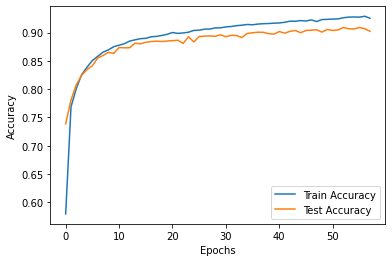

In [8]:
plt.plot(model.history.history['accuracy'],label='Train Accuracy')
plt.plot(model.history.history['val_accuracy'],label='Test Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# plt.savefig('accuracy_plot_1.png')
plt.show()

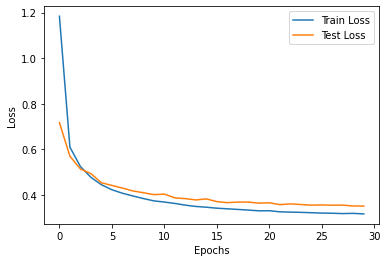

In [16]:
# plt.close()
plt.plot(model.history.history['loss'],label='Train Loss')
plt.plot(model.history.history['val_loss'],label='Test Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.savefig('loss_plot_1.png')
plt.show()

## `LearningRateScheduler` Callback
Every optimizer has a `learning_rate` argument:
* Too low = takes more epochs to achieve a good accuracy
* Too high - will overshoot the minimum and just oscillate around poor values of acuracy.

Another way is to fix it to a medium-high value and reduce it on each epoch. This results in large steps towards the minimum in the start but much slower steps after a while. We can do this using the `LearningRateScheduler` callback.

In [10]:
mnist = tf.keras.datasets.fashion_mnist
(training_images, training_labels), (test_images, test_labels) = mnist.load_data()

training_images = prepare_data(training_images)
test_images = prepare_data(test_images)

model = create_model()

print(model.summary())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 6)         60        
                                                                 
 average_pooling2d_2 (Averag  (None, 15, 15, 6)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 16)        880       
                                                                 
 average_pooling2d_3 (Averag  (None, 6, 6, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten_1 (Flatten)         (None, 576)               0         
                                                                 
 dense_3 (Dense)             (None, 120)              

In [11]:
# Scheduler function that reduces the learning rate by a factor of e^-0.1.
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

callback2 = tf.keras.callbacks.LearningRateScheduler(
    schedule=scheduler,  # Takes epoch index and current learning rate as args, returns a new learning rate as float.
    verbose=1            # 0 = quiet, 1 = update messages
)



## Model

In [12]:
# Compile the Model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

model.fit(
    training_images, 
    training_labels, 
    validation_data=(test_images,test_labels), 
    epochs=30, 
    callbacks=[callback2], 
    batch_size=1024
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/30
59/59 [==============================] - 24s 396ms/step - loss: 1.1839 - accuracy: 0.6468 - val_loss: 0.7169 - val_accuracy: 0.7257 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/30
59/59 [==============================] - 21s 355ms/step - loss: 0.6092 - accuracy: 0.7746 - val_loss: 0.5696 - val_accuracy: 0.7912 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/30
59/59 [==============================] - 21s 353ms/step - loss: 0.5243 - accuracy: 0.8096 - val_loss: 0.5136 - val_accuracy: 0.8142 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/30
59/59 [==============================] - 21s 353ms/step - loss: 0.4768 - accuracy: 0.8281 - val_loss: 0.4931 - val_accuracy: 0.8188 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to

## Plot

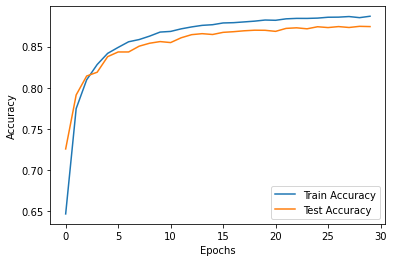

In [13]:
plt.plot(model.history.history['accuracy'],label='Train Accuracy')
plt.plot(model.history.history['val_accuracy'],label='Test Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# plt.savefig('accuracy_plot_2.png')
plt.show()

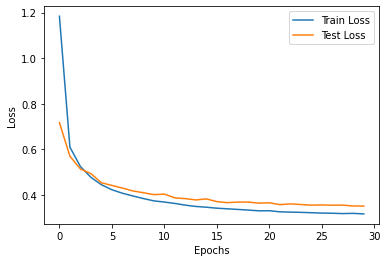

In [15]:
# plt.close()
plt.plot(model.history.history['loss'],label='Train Loss')
plt.plot(model.history.history['val_loss'],label='Test Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.savefig('loss_plot_2.png')
plt.show()